# Importo librerias

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import os
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd

Algunas configuraciones globales:

In [3]:
dir_drive = '' # --> Colocar carpeta del drive y al final poner un /

#------Tamaño de letra en los ejes----------
plt.rcParams['xtick.labelsize'] = 14  # tamaño de los números del eje x
plt.rcParams['ytick.labelsize'] = 14  # tamaño de los números del eje y

# Cargado de archivos

In [16]:
c = 3e8 #m/s
X, err_X, Y, V, nu, err_nu = [], [], [], [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = dir_drive + 'Mediciones/Barrido voltaje dia 3'
fname = os.listdir(folder + '/')
files = fname[:9] + fname[-5:] # --> contiene primeras mediciones y los alts
for file in files:
    root = folder + '/' + file
    if file[:7] == 'barrido':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, err_Xi, Yi, Vi = np.zeros((4, N - 1))
        for i, row in enumerate(medXYV[1:]):
            Xi[i], err_Xi[i], Yi[i], Vi[i] = row[0], row[0]*0.02, row[1], row[2]
        X.append(Xi), err_X.append(err_Xi), Y.append(Yi), V.append(Vi)
        lamb, err_lamb = float(file[-9:-6])*1e-9, .5*1e-9 #m
        nu.append(c / lamb), err_nu.append( np.abs(c / lamb**2) * err_lamb )

# Cálculo de $I$ y $V_0$

In [5]:
# Obtengo el V / I = 0
def V0min(x, v, epsilon = .05e-10, p = -1, M = 5):
    xc = x[(x >= 0) & (x <= epsilon)]
    vc = v[(x >= 0) & (x <= epsilon)]

    xc0, vc0, ind_vc0 = xc[p], vc[p], np.where(v == vc[p])[0]
    err_vc0 = np.max([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])
    
    return xc0, vc0, M * err_vc0

def rectas(I, V):
    #--------Recorto datos para ajuste---------
    I_corte0, V_corte0 = I[10:30], V[10:30]
    I_corte1, V_corte1 = I[(V >= 0) & (V <= .5)], V[(V >= 0) & (V <= .5)]

    #--------Ajuste---------
    lin = lambda x, a, b: a*x + b
    popt0, pcov0 = curve_fit(lin, V_corte0, I_corte0) # --> Línea naranja
    popt1, pcov1 = curve_fit(lin, V_corte1, I_corte1) # --> Línea roja
    m, b = popt0
    m_, b_ = popt1
    
    #--------------------------
    # Buscamos la interseccion
    #--------------------------
    dm, db = (b - b_) / (m_ - m)**2, 1 / (m_ - m)
    dm_, db_ = -dm, -db
    
    V0_comun = (b_ - b) / (m - m_)
    var_v0_comun = dm**2 * ( pcov0[0][0] + pcov1[0][0] ) + 2*dm*db * ( pcov0[0][1] + pcov1[0][1]) + db**2 * ( pcov0[1][1] + pcov1[1][1] )

    return popt0, popt1, V0_comun, np.sqrt(var_v0_comun)


# Gráficos de las mediciones

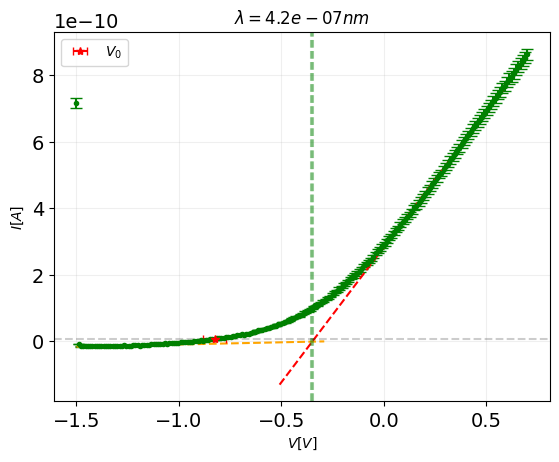

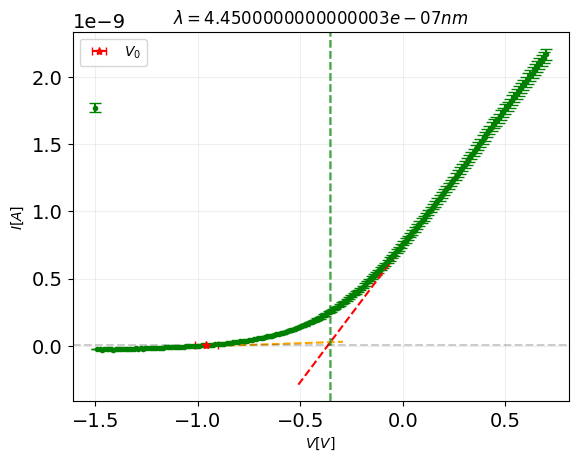

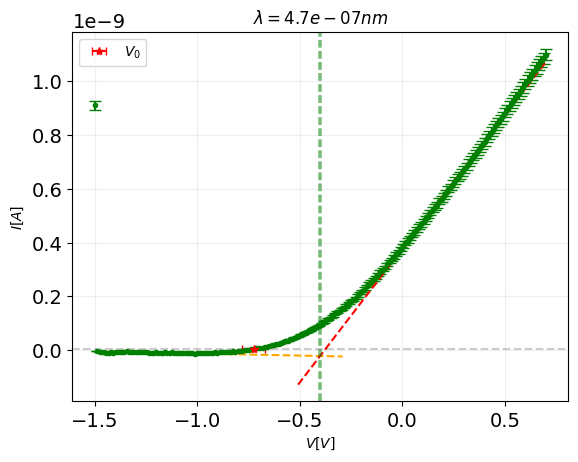

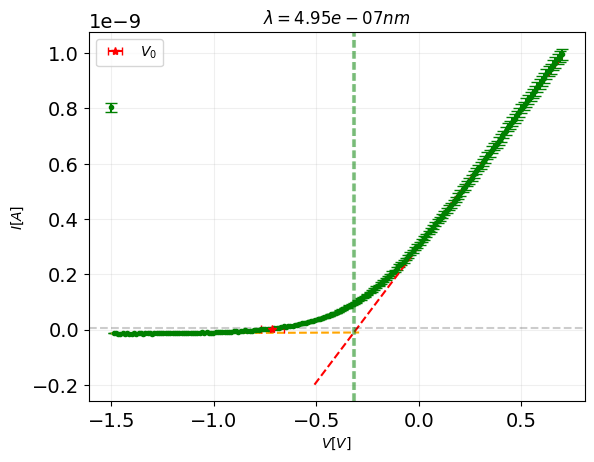

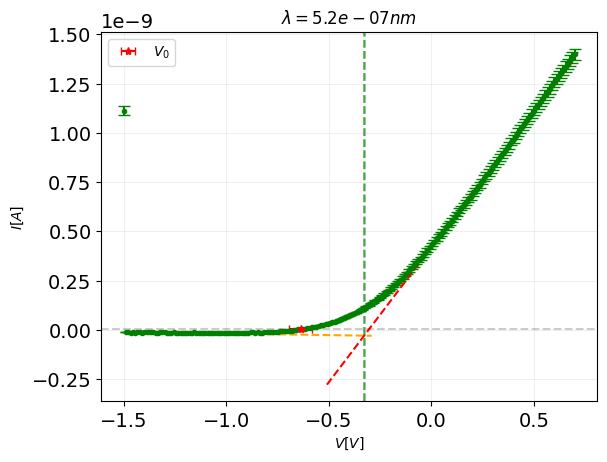

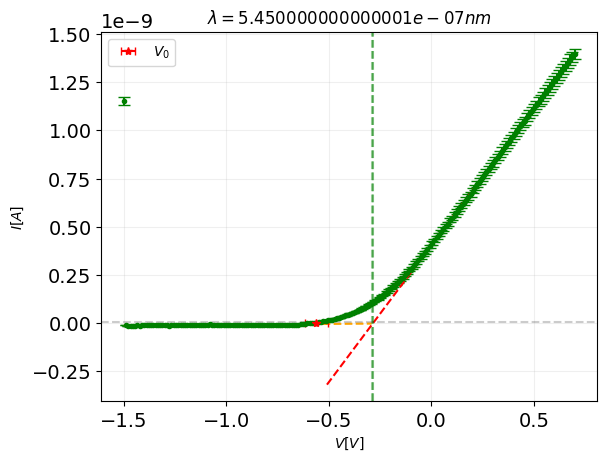

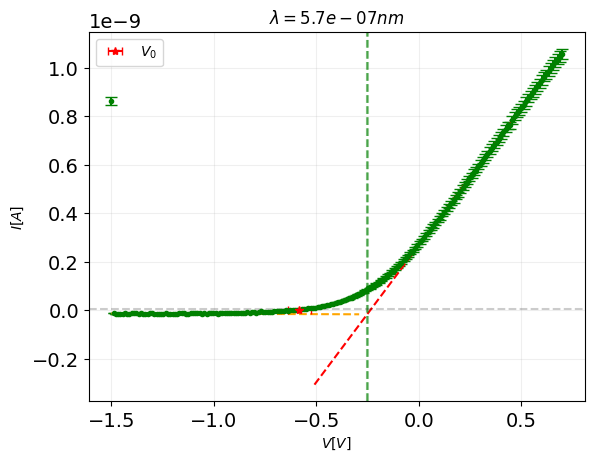

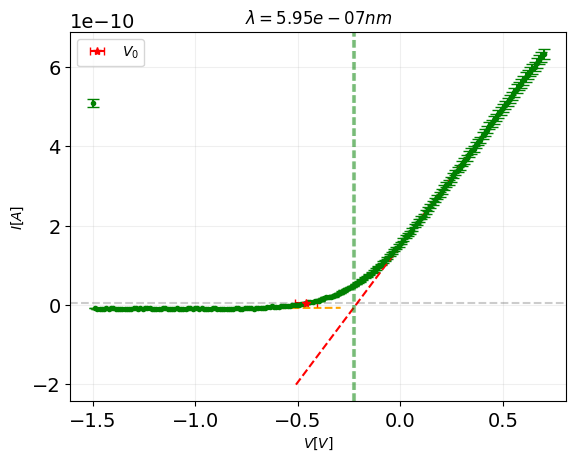

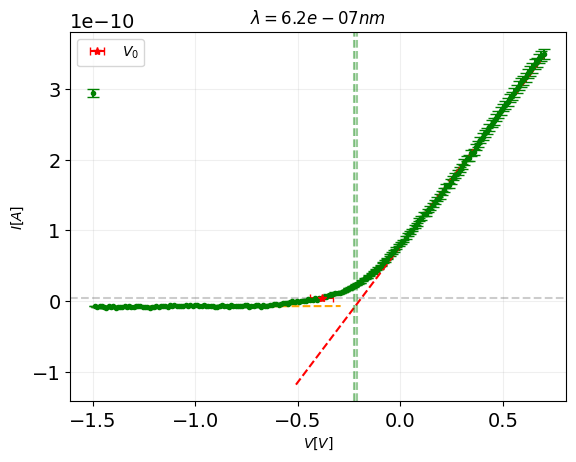

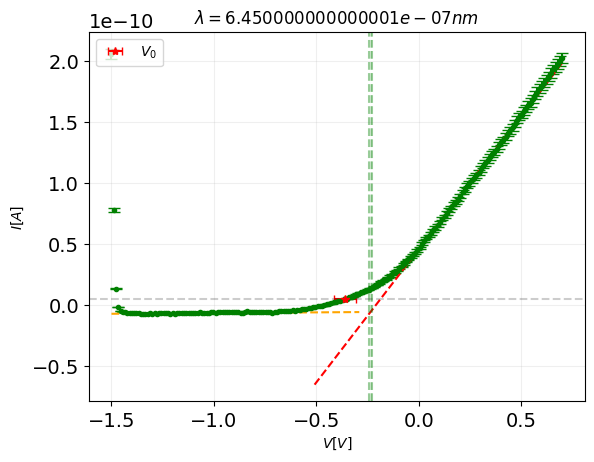

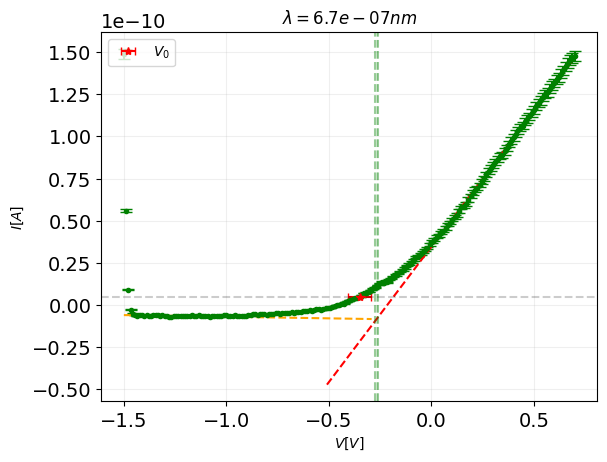

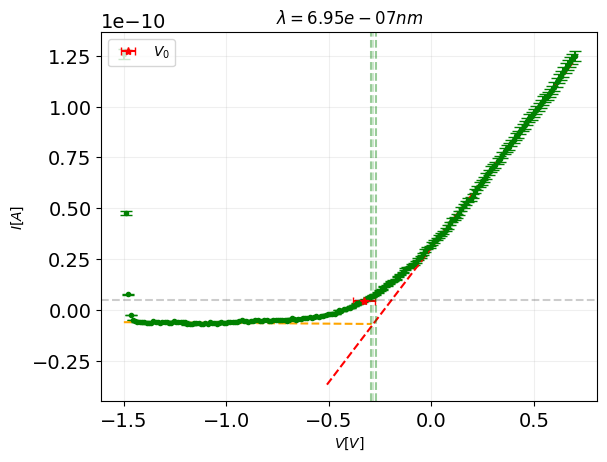

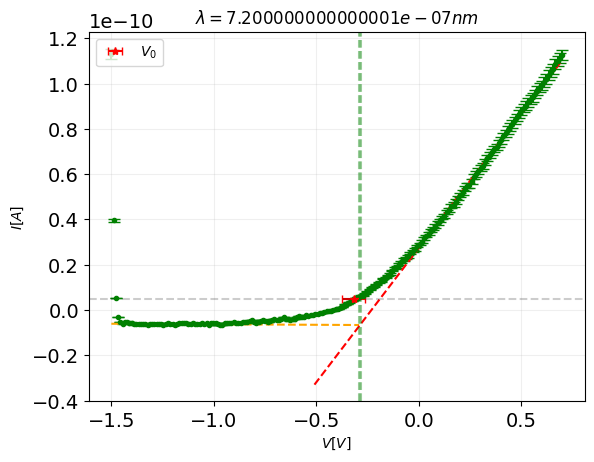

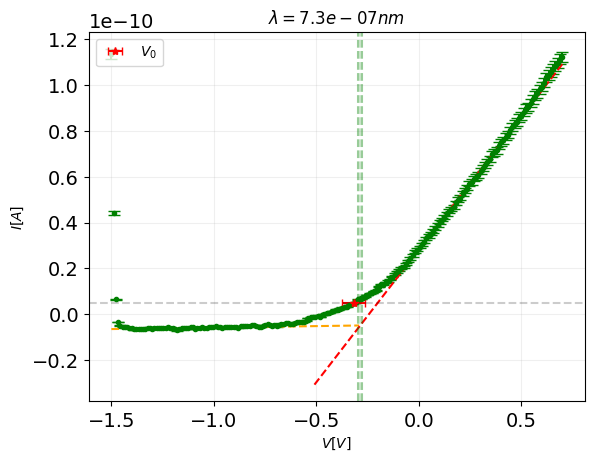

In [9]:
N = len(X)
V0, err_V0, Xc0 = np.zeros((3, N))
V0C, err_V0C = np.zeros((2, N))

ep0 = .05e-10
for k in range(len(X)):
    # ----Calculamos ambos criterios----
    Xc0[k], V0[k], err_V0[k] = V0min(-X[k], V[k])
    p0, p1, V0C[k], err_V0C[k] = rectas(-X[k], V[k])
        
    #---Calculo de las rectas-----
    f = lambda x, a, b: a * x + b
    v_sim = np.linspace(V[k][0], V[k][-1], 1000)

    #----Gráficos----
    plt.figure()
    
    plt.errorbar(V[k], -X[k], yerr = np.abs(err_X[k]), 
                 color = 'green', fmt = '.', capsize = 4)
    plt.plot(v_sim[:-450], f(v_sim, *p0)[:-450], '--', color = 'orange')
    plt.plot(v_sim[450:], f(v_sim, *p1)[450:], '--', color = 'red')

    plt.errorbar(V0[k], Xc0[k], fmt = '*', xerr = err_V0[k], capsize = 3, 
                    linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    plt.axvline(V0C[k], linestyle = '--', color = 'green', alpha = 0.2)
    plt.axvline(V0C[k] + err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    plt.axvline(V0C[k] - err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    
    plt.axhline(ep0, linestyle = '--', color = 'black', alpha = 0.2)
    
    plt.xlabel(r'$V \left[V\right]$'), plt.ylabel(r'$I \left[A\right]$'), plt.title(rf'$\lambda = {c/nu[k]} nm$')
    plt.grid(alpha = 0.2), plt.legend(loc = 'upper left')
    plt.show()

### Figura para el informe

#### Medición de 420 nm

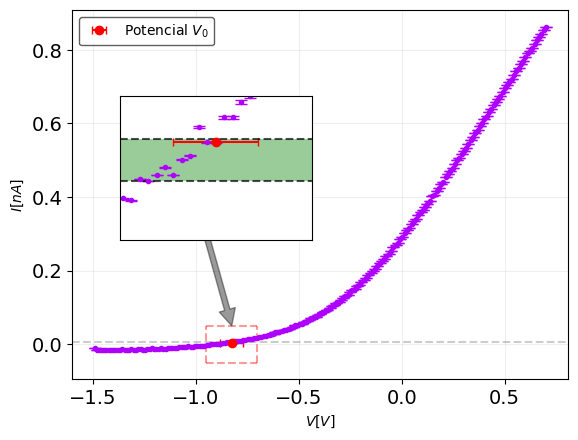

In [11]:
#-------Tomo dato N de las mediciones---------
k = 0

#----Gráficos----

#---------------
# Figura main
#---------------
fig, main_ax = plt.subplots()

main_ax.errorbar(V[k][1:], -X[k][1:] * 1e9, yerr = np.abs(err_X[k][1:]),
                 fmt = '.', capsize = 4, color = "#ae00ff") # --> eliminé el primer punto

main_ax.errorbar(V0[k], Xc0[k] * 1e9, fmt = 'o', xerr = err_V0[k], capsize = 3, 
                linestyle = 'None', color = 'red', label = r'Potencial $V_0$') #-->Puntos de corriente nula

main_ax.axhline(ep0 * 1e9, linestyle = '--', color = 'black', alpha = 0.2)

main_ax.set(xlabel = r'$V \left[V\right]$', ylabel = r'$I \left[nA\right]$')
main_ax.grid(alpha = 0.2), main_ax.legend(loc = 'upper left', edgecolor = "#36363600")


#---------------
# Caja del zoom
#---------------
main_ax.plot([-.7]*2, [-.05, .05], color = 'red', linestyle = '--', alpha = .4) # --> Barra derecha
main_ax.plot([-.95]*2, [-.05, .05], color = 'red', linestyle = '--', alpha = .4) # --> Barra izquierda
main_ax.plot([-.95, -.7], [-.05]*2, color = 'red', linestyle = '--', alpha = .4) # --> Barra abajo
main_ax.plot([-.95, -.7], [.05]*2, color = 'red', linestyle = '--', alpha = .4) # --> Barra arriba

#---------
# Flecha
#---------
main_ax.annotate('', xy = (np.mean([-.95, -.7]), .05), xytext = (-1, .4),
                 arrowprops = dict(facecolor = 'black', alpha = 0.4))

#-------------
# Figura zoom
#-------------
zoom_ax = fig.add_axes([.2, .4, .3, .3], facecolor = 'white')

zoom_ax.errorbar(V[k][1:], -X[k][1:], yerr = np.abs(err_X[k][1:]),
                 fmt = '.', capsize = 4, color = "#ae00ff")
zoom_ax.errorbar(V0[k], Xc0[k], fmt = 'o', xerr = err_V0[k], capsize = 3, 
                linestyle = 'None', color = 'red', label = r'$V_0$')

zoom_ax.axhline(ep0, linestyle = '--', color = 'black', alpha = 0.7)
zoom_ax.axhline(0, linestyle = '--', color = 'black', alpha = 0.7)

zoom_ax.set(xticks = [], yticks = [], 
            ylim = (-.7e-11, 1e-11), xlim = (-.95, -.7))

zoom_ax.fill_between(np.arange(-1, -.4, 0.01), 0, ep0, facecolor = 'green', alpha = 0.4)

plt.savefig(dir_drive + 'Figuras_informe/420nm_medicion.pdf', bbox_inches = 'tight')
plt.show()

#### Resto de mediciones

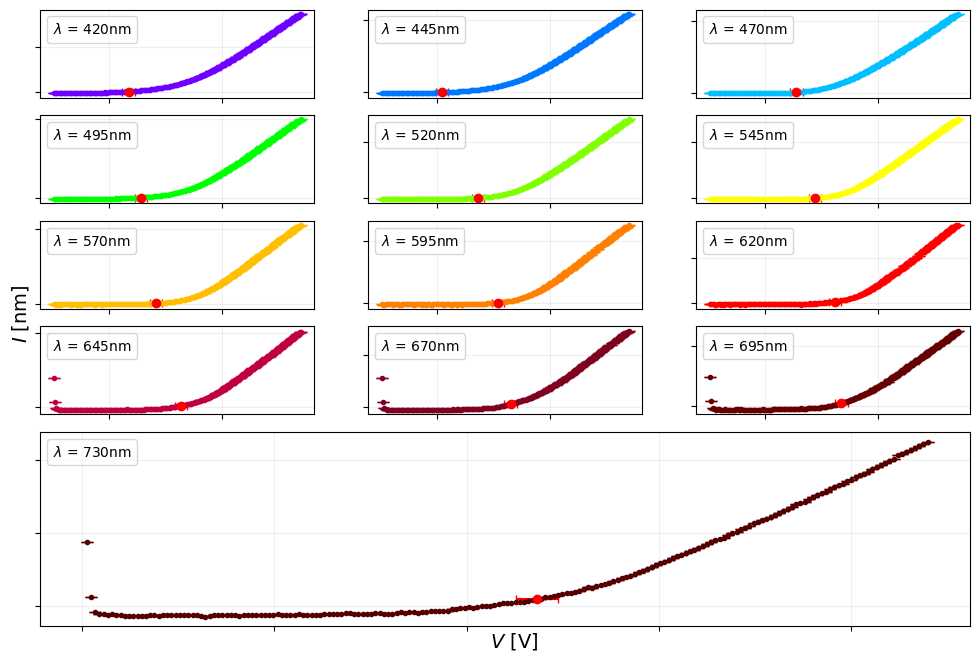

In [13]:
#-----Lista de colores------
colores = [
    '#6f00ff',  # 445 nm, azul violeta
    '#0077ff',  # 470 nm, azul
    '#00bfff',  # 495 nm, azul verdoso
    '#00ff00',  # 520 nm, verde
    '#7fff00',  # 545 nm, verde amarillento
    '#ffff00',  # 570 nm, amarillo
    '#ffbf00',  # 595 nm, amarillo-naranja
    '#ff7f00',  # 620 nm, naranja
    '#ff0000',  # 645 nm, rojo
    '#bf003f',  # 670 nm, rojo profundo
    '#800020',  # 695 nm, rojo oscuro
    '#660000',  # 720 nm, rojo muy oscuro
    '#550000',  # 730 nm, casi infrarrojo
]

fig = plt.figure(figsize = (12, 8))
gs = GridSpec(6, 3, figure = fig)

# Primeros 12 gráficos
k = 0
for i in range(0, 3 + 1, 1):
    for j in range(0, 2 + 1):
        axsij = fig.add_subplot(gs[i, j])
        
        axsij.errorbar(V[k][1:], -X[k][1:] * 1e9, yerr = np.abs(err_X[k][1:]),
                       fmt = '.', capsize = 4, color = colores[k]) # --> eliminé el primer punto
        axsij.errorbar(V0[k], Xc0[k] * 1e9, fmt = 'o', xerr = err_V0[k], capsize = 3, 
                linestyle = 'None', color = 'red') #-->Puntos de corriente nula
        
        texto = r'$\lambda$ = ' + f'{int(np.round(c/nu[k] * 1e9))}nm'
        axsij.plot(V[k][0], -X[k][0] * 1e9, alpha = 0, label = texto)
        
        axsij.tick_params(labelbottom = False, labelleft = False)
        axsij.grid(alpha = 0.2), axsij.legend(handlelength=0, handletextpad=0, loc = 'upper left')
        k += 1

# Último gráfico
axs4 = fig.add_subplot(gs[4:, :])
axs4.errorbar(V[-1][1:], -X[-1][1:] * 1e9, yerr = np.abs(err_X[-1][1:]),
              fmt = '.', capsize = 4, color = colores[-1]) # --> eliminé el primer punto
axs4.errorbar(V0[-1], Xc0[-1] * 1e9, fmt = 'o', xerr = err_V0[-1], capsize = 3, 
        linestyle = 'None', color = 'red') #-->Puntos de corriente nula

texto = r'$\lambda$ = ' + f'{int(np.round(c/nu[-1] * 1e9))}nm'
axs4.plot(V[k][0], -X[k][0] * 1e9, alpha = 0, label = texto)
axs4.tick_params(labelbottom = False, labelleft = False), axs4.legend(handlelength=0, handletextpad=0, loc = 'upper left')
axs4.grid(alpha = 0.2)

# Coloco labels laterales
fig.text(.1, .5, r'$I$ [nm]', va='center', rotation='vertical', fontsize=14)
fig.text(.5, .09, r'$V$ [V]', va='center', rotation='horizontal', fontsize=14)

plt.savefig(dir_drive + 'Figuras_informe/medicion_voltajes.pdf', bbox_inches = 'tight')
plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

199
11.521423254853921 1.0
Método visual : 3.33015751031381e-34 +- 2.5019993024024667e-35
Método rectas : 8.404985524648144e-35 +- 1.722546716978497e-35


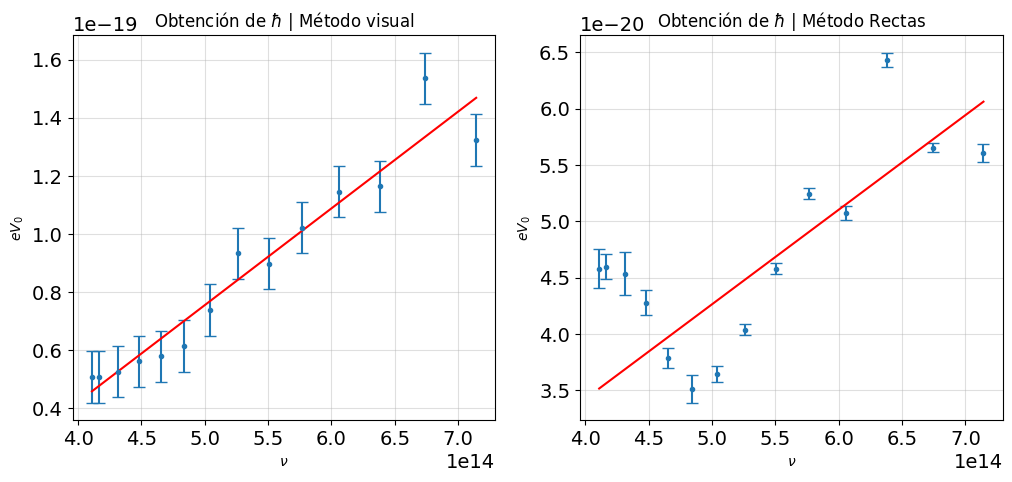

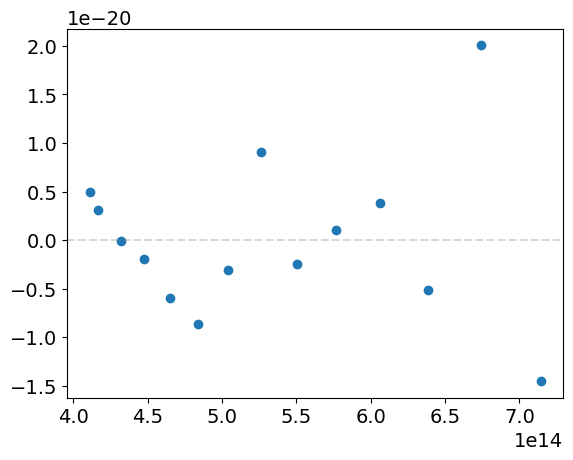

In [19]:
# Defino e y paso a arrayos
elect = -1.60217663e-19 #C
V0, err_V0 = np.array(V0), np.array(err_V0)
V0C, err_V0C = np.array(V0C), np.array(err_V0C)
nu, err_nu = np.array(nu), np.array(err_nu)

# ------------Ajuste lineal------------
f = lambda x, a, c: a * x + c

# --> Ajuste para método visual
popt, pcov = curve_fit(f, nu, elect*V0, sigma = elect*err_V0, p0 = [6e-34, 1.4e-19], absolute_sigma = True)
h, err_h = popt[0], np.sqrt(np.diag(pcov))[0]

#chi2
df = N - 2
print(df)
Chi2 = sum( ( (elect*V0 - f(nu, *popt)) / (elect*err_V0) )**2 )
p_valor = 1 - chi2(df = df).cdf(Chi2)
print(Chi2, p_valor)

# --> Ajuste para método por rectas
poptC, pcovC = curve_fit(f, nu, elect*V0C, sigma = elect*err_V0C)
hC, err_hC = poptC[0], np.sqrt(np.diag(pcovC))[0]


# -----------Gráfico de ajustes----------
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# ---> Método visual
axs[0].errorbar(nu, elect*V0, fmt = '.', yerr = -elect*err_V0, capsize = 4)
axs[0].plot(nu, f(np.array(nu), *popt), color = 'red')
axs[0].set(title = r'Obtención de $\hbar$ | Método visual', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[0].grid(alpha = 0.4)

# ---> Método rectas
axs[1].errorbar(nu, elect*V0C, fmt = '.', yerr = -elect*err_V0C, capsize = 4)
axs[1].plot(nu, f(np.array(nu), *poptC), color = 'red')
axs[1].set(title = r'Obtención de $\hbar$ | Método Rectas', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[1].grid(alpha = 0.4)

print(f'Método visual : {h} +- {err_h}')
print(f'Método rectas : {hC} +- {err_hC}')

#---------------------
# Gráfico de residuos
#---------------------
plt.figure()
plt.scatter(nu, elect*V0 - f(np.array(nu), *popt))
plt.axhline(0, linestyle = '--', color = 'gray', alpha = 0.3)
plt.show()

### Figura para el informe

<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_17348\2436815406.py:38: SyntaxWarning: invalid escape sequence '\c'
  """


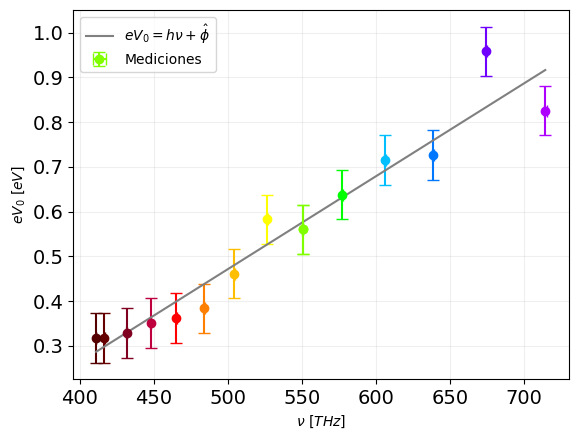

In [20]:
#-----Lista de colores------
colores = [
    '#ae00ff',  # 420 nm, violeta
    '#6f00ff',  # 445 nm, azul violeta
    '#0077ff',  # 470 nm, azul
    '#00bfff',  # 495 nm, azul verdoso
    '#00ff00',  # 520 nm, verde
    '#7fff00',  # 545 nm, verde amarillento
    '#ffff00',  # 570 nm, amarillo
    '#ffbf00',  # 595 nm, amarillo-naranja
    '#ff7f00',  # 620 nm, naranja
    '#ff0000',  # 645 nm, rojo
    '#bf003f',  # 670 nm, rojo profundo
    '#800020',  # 695 nm, rojo oscuro
    '#660000',  # 720 nm, rojo muy oscuro
    '#550000',  # 730 nm, casi infrarrojo
]

#-----Figura-------
fig, axs = plt.subplots()

#-----------------
# Figura principal
#-----------------
for n in range(len(nu)):
    axs.errorbar(nu[n] * 1e-12, elect*V0[n] * 6.242e+18, color = colores[n], 
             fmt = 'o', capsize = 4, yerr = -elect*err_V0[n]*6.242e+18, xerr = err_nu[n] * 1e-12) #--> Pase de Joules a ev y Hz a THz

axs.plot(nu * 1e-12, f(nu, *popt) * 6.242e+18, '-', color = 'gray', label = r'$eV_0 = h\nu + \hat{\phi}$')

axs.errorbar(nu[5] * 1e-12, elect*V0[5] * 6.242e+18, color = colores[5], 
             fmt = 'o', capsize = 4, yerr = -elect*err_V0[5]*6.242e+18, xerr = err_nu[5] * 1e-12,
             alpha = 1, label = 'Mediciones')

axs.set(ylabel = r'$eV_0$ $[eV]$', xlabel = r'$\nu$ $[THz]$')
axs.grid(alpha = 0.2), axs.legend(loc = 'upper left')

"""
#--------------
# Caja con info
#--------------
bbox = {
    'boxstyle': 'round4',
    'facecolor': "#D3BE06",
    'edgecolor': 'black',
    'linewidth': 2
}
texto = r'$\chi^2$ = ' + f'{np.round(Chi2)}\n' + r'$p_{value}$ = ' + f'{np.round(p_valor, 2)}\n' + r'$h = (kk \pm kk)$'
axs.annotate(texto, xy = (420, 0.8), bbox = bbox)
"""

plt.savefig(dir_drive + 'Figuras_informe/ajuste_h.pdf', bbox_inches = 'tight')
plt.show()

## Barrido de longitudes (dia 3)

### Cargamos los datos

In [26]:
# Cargamos los dataframes
df = pd.read_csv(dir_drive + 'Mediciones/Barrido de longitudes/medicion_completa.csv')
long_ond, err_long_onda = np.array(df['long']) / 1e9, 0.5 / 1e9 # m
I_5v, err_I_5v = -df['X'], -df['X'] * 0.02
nu_odna, err_nu_odna = c / long_ond, np.abs(c / long_ond**2) * err_long_onda

### Usamos criterios de selección

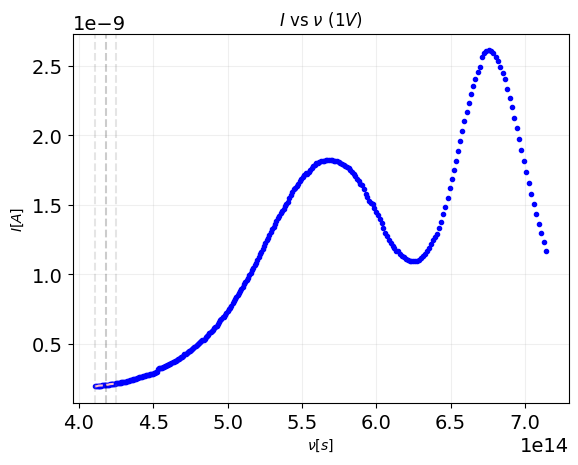

In [23]:
#--------------------
# Criterio de nu_min
#--------------------

# Busco los valores
nus = nu_odna[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)]
Is = np.array(I_5v[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)])

# Tomo promedios y como error la mayor distancia
nu0, I_nu0 = np.mean(nus), np.mean(Is)
err_nu0 = np.mean([nu0 - nus[0], nus[-1] - nu0])

#--------
# Figura
#--------
plt.figure()

plt.plot(nu_odna, I_5v, '.', color = 'blue')
plt.plot(nus, Is, '--', color = 'pink')

plt.axvline(nu0, linestyle = '--', color = 'black', alpha = 0.2)
plt.axvline(nu0 + err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)
plt.axvline(nu0 - err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)

plt.title(r'$I$ vs $\nu$ $(1V)$'), plt.ylabel(r'$I[A]$'), plt.xlabel(r'$\nu[s]$')
#plt.xlim(4e14, 4.2e14)
plt.grid(alpha = 0.2)
plt.show()

In [24]:
# Calculos del potencial
pot, err_pot = nu0 * h, np.sqrt(h**2 * err_nu0**2 + nu0**2 * err_h**2)

print(pot, err_pot)

1.3915710912205367e-19 1.0710739763982383e-20


### Figura para el informe

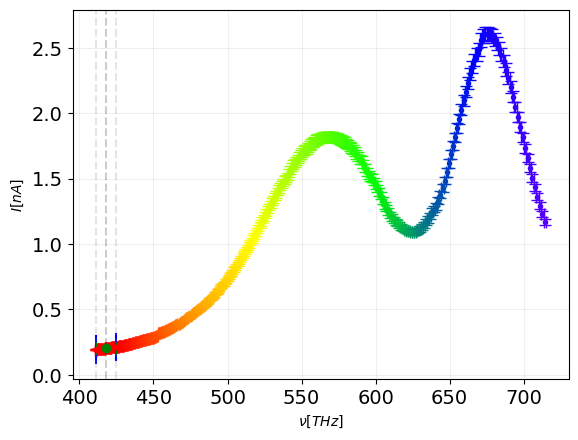

In [29]:
#------Boludes para los colores del gráfico------
from matplotlib.colors import LinearSegmentedColormap
colors = [
    (400, "#8B00FF"), # violeta
    (450, "#0000FF"), # azul
    (500, "#00FF00"), # verde
    (580, "#FFFF00"), # amarillo
    (700, "#FF0000"), # rojo
]

wavelengths, hex_colors = zip(*colors)
wavelengths = np.array(wavelengths)
wavelengths_norm = (wavelengths - 400) / (700 - 400)

cmap = LinearSegmentedColormap.from_list("visible_spectrum",
                                         list(zip(wavelengths_norm, hex_colors)))
lam_norm = (long_ond * 1e9 - 400) / (700 - 400)
lam_norm = np.clip(lam_norm, 0, 1)  # aseguramos estar dentro del rango

#-------Figura-----------
fig, axs = plt.subplots()
"""
axs.scatter(nu_odna * 1e-12, I_5v * 1e9, c=cmap(lam_norm), s = 10) #A -> nA | Hz -> THz
"""
for x, y, col, err_x, err_y in zip(nu_odna * 1e-12, I_5v * 1e9, cmap(lam_norm), err_nu_odna * 1e-12, err_I_5v * 1e9):
    axs.errorbar(x, y, xerr = err_x, yerr = err_y, 
                 color = col, fmt = '.', capsize = 4)

#-------------
# Criterio
#-------------

# Marco línea de los puntos que tomamos
axs.plot(nus * 1e-12, Is * 1e9, '-', color = 'blue')
axs.plot([nus[-1] * 1e-12, nus[-1] * 1e-12], [Is[-1]*1e9 + .1, Is[-1]*1e9 - .1], color = 'blue')
axs.plot([nus[0] * 1e-12, nus[0] * 1e-12], [Is[0]*1e9 + .1, Is[0]*1e9 - .1], color = 'blue')

# Marco extremos que tomamos como error
axs.axvline(nu0 * 1e-12, linestyle = '--', color = 'black', alpha = 0.2)
axs.axvline(nu0 * 1e-12 + err_nu0 * 1e-12, linestyle = '--', color = 'gray', alpha = 0.2)
axs.axvline(nu0 * 1e-12 - err_nu0 * 1e-12, linestyle = '--', color = 'gray', alpha = 0.2)

# Marco el punto con su error
axs.errorbar(nu0 * 1e-12, I_nu0 * 1e9, fmt = 'o', color = 'green',
             xerr = err_nu0 * 1e-12, capsize = 4)

axs.set(xlabel = r'$\nu[THz]$', ylabel = r'$I[nA]$')
plt.grid(alpha = 0.2)
plt.savefig(dir_drive + 'Figuras_informe/barridonu.pdf', bbox_inches = 'tight')

[Text(0.5, 0, '$V$ [V]'), Text(0, 0.5, '$I$ [a]')]

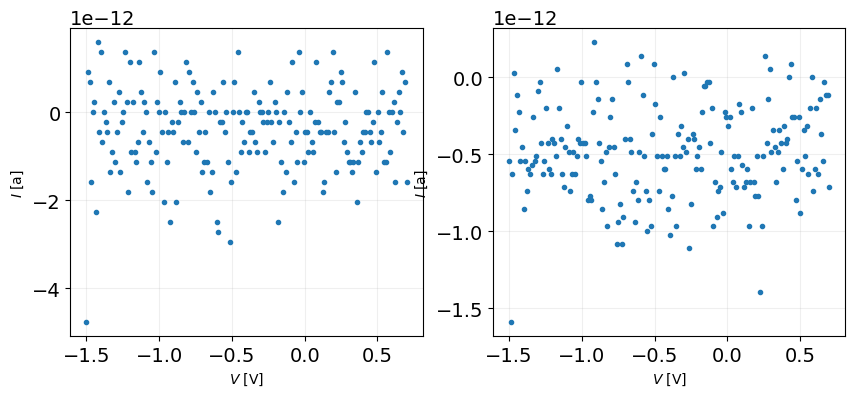

In [40]:
df = pd.read_csv('Mediciones/ruido.csv')
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].plot(df['V'], -df['X'], '.')
axs[0].grid(alpha = 0.2)
axs[0].set(xlabel = r'$V$ [V]', ylabel = r'$I$ [a]')

df = pd.read_csv('Mediciones/alt_ruido.csv')
axs[1].plot(df['V'], -df['X'], '.')
axs[1].grid(alpha = 0.2)
axs[1].set(xlabel = r'$V$ [V]', ylabel = r'$I$ [a]')
